In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# be careful with that:
import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures


from sklearn.linear_model import LogisticRegression


from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

from sklearn.ensemble import IsolationForest


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, confusion_matrix, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, adjusted_rand_score, precision_recall_curve, precision_score

from sklearn.svm import OneClassSVM

from scipy.stats import uniform, chisquare, binomtest

from itertools import product

from IPython.display import clear_output


In [15]:
!python3 pca_pipeline.py 333346 200 '../datasets/train/data_heatmap_train.csv'
grid_id = 333346

import pandas as pd
pca_df = pd.read_csv('temp/pca_df.csv')
normalized_input = pd.read_csv('temp/normalized_input.csv')
# X_train = normalized_input.iloc[:,2:-1]
# y_train = normalized_input.iloc[:,-1]

Grid ID:  333346
Nb components:  200
Data directory:  ../datasets/train/data_heatmap_train.csv


In [16]:
pca_df = pca_df.iloc[:,1:]

# One Class SVM

In [17]:
y = pca_df[['label']]
actual_labels = y['label'].values

In [18]:
pca_df_inp = pca_df.iloc[:,:-2]
best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for pca_dim in np.linspace(2,200,198).astype(int):
    X = pca_df_inp.iloc[:,:pca_dim]
    
    oneclass = OneClassSVM(gamma = 'auto').fit(X)
    oneclass_labels = oneclass.predict(X)
    
    oneclass_labels = np.where(oneclass_labels == 1, 0,1)
    
    conf_mat   = confusion_matrix(actual_labels,oneclass_labels)
    acc        = accuracy_score(actual_labels,oneclass_labels)
    recall     = recall_score(actual_labels,oneclass_labels)
    prec       = precision_score(actual_labels,oneclass_labels)
    
    if acc > best_acc:
        best_acc = acc
        best_dim = pca_dim
        best_recall  = recall
        best_prec = prec
        
        best_oneclass_labels = oneclass_labels
        
        print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
              f' {conf_mat}')
        print(f'Accuracy for {pca_dim} PCA dimensions:', 
              f' {acc:.2f}')
        print(f'Recall for {pca_dim} PCA dimensions:', 
              f' {recall:.2f}')
        print(f'Precision for {pca_dim} PCA dimensions:', 
              f' {prec:.2f}')
        print(f'---------')

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     sns.scatterplot(x=X.iloc[:, 0], 
#                     y=X.iloc[:, 1], 
#                     hue=actual_labels, 
#                     style=actual_labels, 
#                     palette='viridis')
#     plt.title('Actual Labels')

#     plt.subplot(1, 2, 2)
#     sns.scatterplot(x=X.iloc[:, 0], 
#                     y=X.iloc[:, 1], 
#                     hue=oneclass_labels, 
#                     style=oneclass_labels, 
#                     palette='viridis')
#     plt.title('One Class Clustering Result')
#     plt.show()

Confusion matrix for 2 PCA dimensions:
  [[302 221]
 [  0  79]]
Accuracy for 2 PCA dimensions:  0.63
Recall for 2 PCA dimensions:  1.00
Precision for 2 PCA dimensions:  0.26
---------
Confusion matrix for 5 PCA dimensions:
  [[303 220]
 [  0  79]]
Accuracy for 5 PCA dimensions:  0.63
Recall for 5 PCA dimensions:  1.00
Precision for 5 PCA dimensions:  0.26
---------
Confusion matrix for 20 PCA dimensions:
  [[307 216]
 [  0  79]]
Accuracy for 20 PCA dimensions:  0.64
Recall for 20 PCA dimensions:  1.00
Precision for 20 PCA dimensions:  0.27
---------
Confusion matrix for 28 PCA dimensions:
  [[308 215]
 [  0  79]]
Accuracy for 28 PCA dimensions:  0.64
Recall for 28 PCA dimensions:  1.00
Precision for 28 PCA dimensions:  0.27
---------
Confusion matrix for 46 PCA dimensions:
  [[321 202]
 [  3  76]]
Accuracy for 46 PCA dimensions:  0.66
Recall for 46 PCA dimensions:  0.96
Precision for 46 PCA dimensions:  0.27
---------
Confusion matrix for 51 PCA dimensions:
  [[328 195]
 [  9  70]]
Acc

# KNN

In [19]:
pca_df_inp = pca_df.iloc[:,:-2]
kchoices = [1,2,5,10]
thres    = [90, 95, 99]

best_acc = -float('inf')
best_dim = -1
for pca_dim in np.linspace(2,200,100).astype(int):
    for ks in kchoices:
        for an_thres in thres:
            
            X   = pca_df_inp.iloc[:,:pca_dim]
            knn = NearestNeighbors(n_neighbors = ks, 
                                   algorithm = 'auto', 
                                   metric = 'euclidean')

            knn_fit = knn.fit(X)
            actual_labels = y['label'].values

            distances, indices = knn.kneighbors(X)
            anomaly_scores = distances.mean(axis=1)

            threshold  = np.percentile(anomaly_scores, an_thres)
            knn_labels = anomaly_scores > threshold

            conf_mat = confusion_matrix(actual_labels,knn_labels)
            acc        = accuracy_score(actual_labels,knn_labels)
            
            if acc > best_acc:
                best_knn_labels = knn_labels
                best_acc = acc
                best_dim = pca_dim
                print(f'Confusion matrix for {pca_dim} PCA dimensions, {an_thres} threshold and {ks}-NN:\n', 
                      f' {conf_mat}')
                print(f'Accuracy for {pca_dim} PCA dimensions, {an_thres} threshold and {ks}-NN:', 
                      f' {acc:.2f}')
                print(f'---------')

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)

# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=actual_labels, 
#                 style=actual_labels, 
#                 palette='viridis')
# plt.title('Actual Labels')

# plt.subplot(1, 2, 2)
# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=knn_labels, 
#                 style=knn_labels, 
#                 palette='viridis')
# plt.title('KMeans Clustering Result')
# plt.show()

Confusion matrix for 2 PCA dimensions, 90 threshold and 1-NN:
  [[523   0]
 [ 79   0]]
Accuracy for 2 PCA dimensions, 90 threshold and 1-NN:  0.87
---------
Confusion matrix for 2 PCA dimensions, 90 threshold and 2-NN:
  [[504  19]
 [ 37  42]]
Accuracy for 2 PCA dimensions, 90 threshold and 2-NN:  0.91
---------
Confusion matrix for 2 PCA dimensions, 90 threshold and 5-NN:
  [[507  16]
 [ 34  45]]
Accuracy for 2 PCA dimensions, 90 threshold and 5-NN:  0.92
---------
Confusion matrix for 2 PCA dimensions, 90 threshold and 10-NN:
  [[509  14]
 [ 32  47]]
Accuracy for 2 PCA dimensions, 90 threshold and 10-NN:  0.92
---------
Confusion matrix for 4 PCA dimensions, 90 threshold and 2-NN:
  [[511  12]
 [ 30  49]]
Accuracy for 4 PCA dimensions, 90 threshold and 2-NN:  0.93
---------
Confusion matrix for 4 PCA dimensions, 90 threshold and 5-NN:
  [[514   9]
 [ 27  52]]
Accuracy for 4 PCA dimensions, 90 threshold and 5-NN:  0.94
---------
Confusion matrix for 4 PCA dimensions, 90 threshold and 

# Kmeans

Adjusted Rand Index (ARI) score: 0.8341874517573497


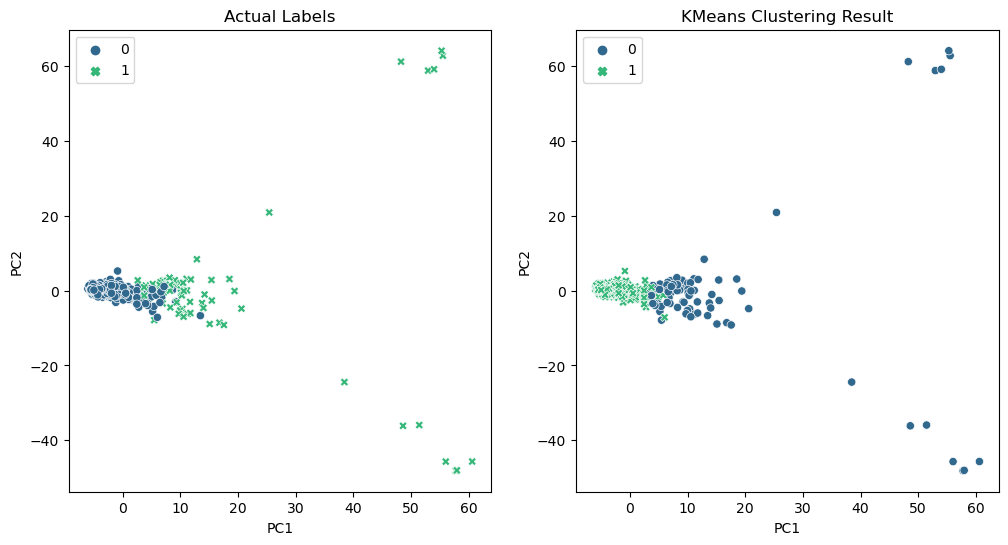

In [20]:
kmeans = KMeans(n_clusters = 2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

actual_labels = y['label'].values

ari_score = adjusted_rand_score(actual_labels, kmeans_labels)

print(f"Adjusted Rand Index (ARI) score: {ari_score}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=actual_labels, 
                style=actual_labels, 
                palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=kmeans_labels, 
                style=kmeans_labels, 
                palette='viridis')
plt.title('KMeans Clustering Result')
plt.show()


In [41]:
pca_df_inp = pca_df.iloc[:,:-2]
kchoices = [1,2,5,10]
thres    = [90, 95, 99]

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    X   = pca_df_inp.iloc[:,:pca_dim]
    kmeans = KMeans(n_clusters = 2, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    
    conf_mat   = confusion_matrix(actual_labels,kmeans_labels)
    acc        = accuracy_score(actual_labels,kmeans_labels)
    recall     = recall_score(actual_labels,kmeans_labels)
    prec       = precision_score(actual_labels,kmeans_labels)
    
    if acc > best_acc or recall > best_recall or prec > best_prec:
        best_acc = acc
        best_dim = pca_dim
        best_recall  = recall
        best_prec = prec
        best_kmeans_labels = kmeans_labels
        print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
              f' {conf_mat}')
        print(f'Accuracy for {pca_dim} PCA dimensions:', 
              f' {acc:.2f}')
        print(f'Recall for {pca_dim} PCA dimensions:', 
              f' {recall:.2f}')
        print(f'Precision for {pca_dim} PCA dimensions:', 
              f' {prec:.2f}')
        print(f'---------')

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)

# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=actual_labels, 
#                 style=actual_labels, 
#                 palette='viridis')
# plt.title('Actual Labels')

# plt.subplot(1, 2, 2)
# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=knn_labels, 
#                 style=knn_labels, 
#                 palette='viridis')
# plt.title('KMeans Clustering Result')
# plt.show()

Confusion matrix for 2 PCA dimensions:
  [[570   0]
 [ 38   2]]
Accuracy for 2 PCA dimensions:  0.94
Recall for 2 PCA dimensions:  0.05
Precision for 2 PCA dimensions:  1.00
---------
Confusion matrix for 12 PCA dimensions:
  [[475  95]
 [  3  37]]
Accuracy for 12 PCA dimensions:  0.84
Recall for 12 PCA dimensions:  0.93
Precision for 12 PCA dimensions:  0.28
---------
Confusion matrix for 16 PCA dimensions:
  [[  0 570]
 [  2  38]]
Accuracy for 16 PCA dimensions:  0.06
Recall for 16 PCA dimensions:  0.95
Precision for 16 PCA dimensions:  0.06
---------
Confusion matrix for 20 PCA dimensions:
  [[ 98 472]
 [ 40   0]]
Accuracy for 20 PCA dimensions:  0.16
Recall for 20 PCA dimensions:  0.00
Precision for 20 PCA dimensions:  0.00
---------
Confusion matrix for 22 PCA dimensions:
  [[476  94]
 [  3  37]]
Accuracy for 22 PCA dimensions:  0.84
Recall for 22 PCA dimensions:  0.93
Precision for 22 PCA dimensions:  0.28
---------
Confusion matrix for 24 PCA dimensions:
  [[570   0]
 [ 39   1]]

# DBScan

Adjusted Rand Index (ARI) score: 0.218989973763926


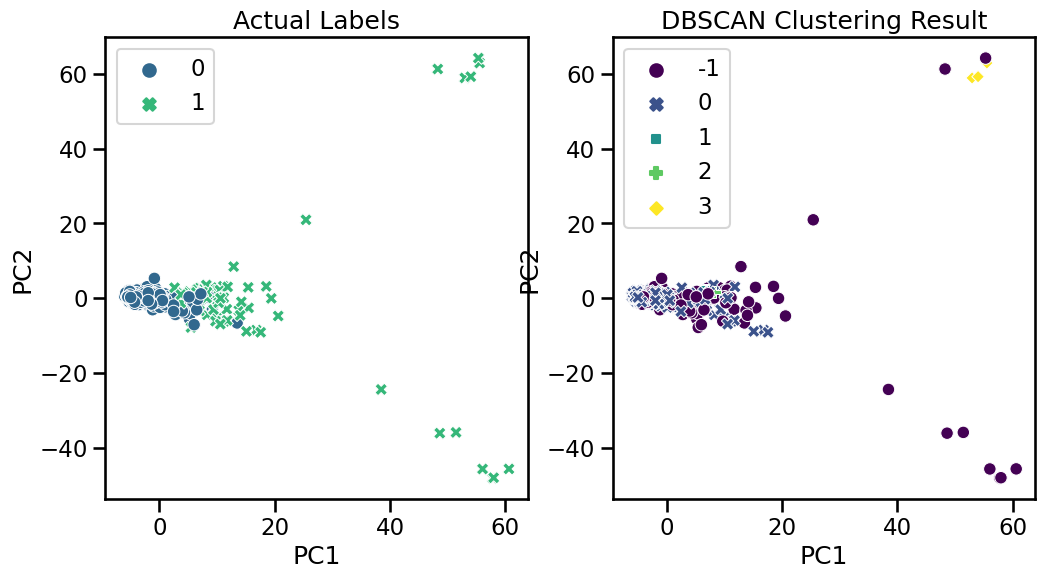

In [22]:
dbscan = DBSCAN(eps = 50, 
                min_samples = 3)

dbscan_labels = dbscan.fit_predict(X)

actual_labels = y['label'].values
ari_score = adjusted_rand_score(actual_labels, dbscan_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

sns.set_context("talk")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=actual_labels, 
                style=actual_labels, 
                palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=dbscan_labels, 
                style=dbscan_labels, 
                palette='viridis')
plt.title('DBSCAN Clustering Result')
plt.show()

In [23]:
pca_df_inp = pca_df.iloc[:,:-2]
epsilons = [5,10,20,30,40,50,60,70,80,90,100]
min_samps = [2,3,4,5,10]

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    for eps in epsilons:
        for ms in min_samps:

            X   = pca_df_inp.iloc[:,:pca_dim]

            dbscan = DBSCAN(eps = eps, 
                        min_samples = ms)
            dbscan_labels = dbscan.fit_predict(X)
            dbscan_labels = np.where(dbscan_labels>=0, 0, 1)

            conf_mat   = confusion_matrix(actual_labels,dbscan_labels)
            acc        = accuracy_score(actual_labels,dbscan_labels)
            recall     = recall_score(actual_labels,dbscan_labels)
            prec       = precision_score(actual_labels,dbscan_labels)

            if acc > best_acc:
                best_acc = acc
                best_dim = pca_dim
                best_recall  = recall
                best_prec = prec
                best_dbscan_labels = dbscan_labels
                print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
                      f' {conf_mat}')
                print(f'Accuracy for {pca_dim} PCA dimensions:', 
                      f' {acc:.2f}')
                print(f'Recall for {pca_dim} PCA dimensions:', 
                      f' {recall:.2f}')
                print(f'Precision for {pca_dim} PCA dimensions:', 
                      f' {prec:.2f}')
                print(f'---------')

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)

# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=actual_labels, 
#                 style=actual_labels, 
#                 palette='viridis')
# plt.title('Actual Labels')

# plt.subplot(1, 2, 2)
# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=knn_labels, 
#                 style=knn_labels, 
#                 palette='viridis')
# plt.title('KMeans Clustering Result')
# plt.show()

Confusion matrix for 2 PCA dimensions:
  [[523   0]
 [ 75   4]]
Accuracy for 2 PCA dimensions:  0.88
Recall for 2 PCA dimensions:  0.05
Precision for 2 PCA dimensions:  1.00
---------
Confusion matrix for 2 PCA dimensions:
  [[523   0]
 [ 73   6]]
Accuracy for 2 PCA dimensions:  0.88
Recall for 2 PCA dimensions:  0.08
Precision for 2 PCA dimensions:  1.00
---------
Confusion matrix for 2 PCA dimensions:
  [[523   0]
 [ 65  14]]
Accuracy for 2 PCA dimensions:  0.89
Recall for 2 PCA dimensions:  0.18
Precision for 2 PCA dimensions:  1.00
---------
Confusion matrix for 2 PCA dimensions:
  [[523   0]
 [ 62  17]]
Accuracy for 2 PCA dimensions:  0.90
Recall for 2 PCA dimensions:  0.22
Precision for 2 PCA dimensions:  1.00
---------
Confusion matrix for 4 PCA dimensions:
  [[522   1]
 [ 54  25]]
Accuracy for 4 PCA dimensions:  0.91
Recall for 4 PCA dimensions:  0.32
Precision for 4 PCA dimensions:  0.96
---------
Confusion matrix for 4 PCA dimensions:
  [[522   1]
 [ 52  27]]
Accuracy for 4 P

# Isolation Forest

              precision    recall  f1-score   support

           0       0.87      1.00      0.93       523
           1       0.00      0.00      0.00        79

    accuracy                           0.87       602
   macro avg       0.43      0.50      0.46       602
weighted avg       0.75      0.87      0.81       602

Accuracy Score: 0.8687707641196013


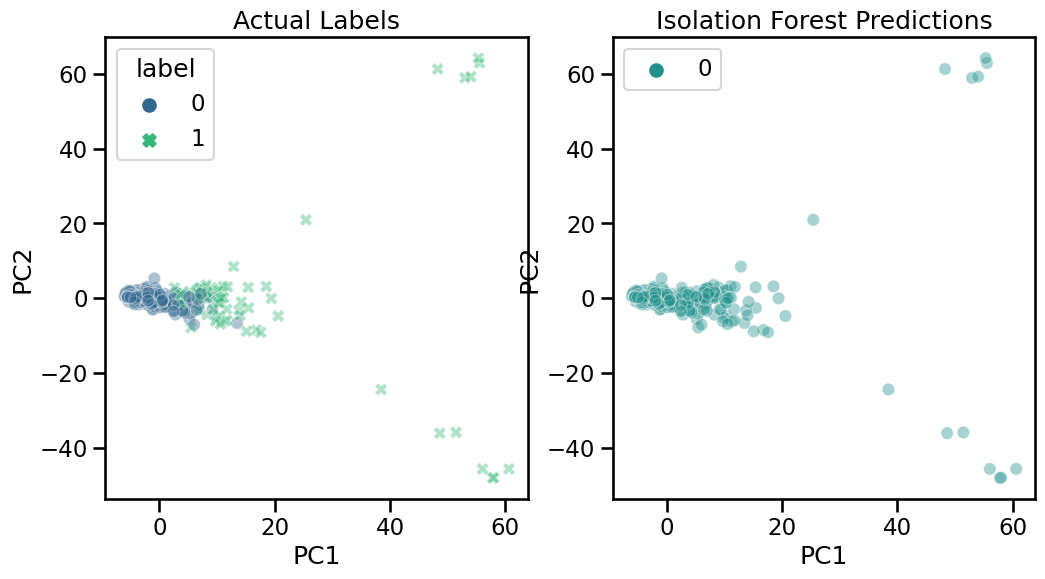

In [24]:
isolation_forest = IsolationForest(n_estimators=100, 
                                   contamination='auto', 
                                   random_state=42)

preds = isolation_forest.fit_predict(X)

binary_preds = np.where(preds == -1, 1, 0)

print(classification_report(y['label'], binary_preds))
print(f"Accuracy Score: {accuracy_score(y['label'], binary_preds)}")

plt.figure(figsize=(12, 6))
sns.set_context("talk")

plt.subplot(1, 2, 1)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=y['label'], 
                style=y['label'], 
                palette='viridis', 
                alpha = 0.4)
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=binary_preds, 
                style=binary_preds, 
                palette='viridis', 
                alpha = 0.4)
plt.title('Isolation Forest Predictions')
plt.show()

In [25]:
pca_df_inp = pca_df.iloc[:,:-2]
n_estims = [5,10,50,100,150,200]

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    for nests in n_estims:
            X   = pca_df_inp.iloc[:,:pca_dim]
            
            isolation_forest = IsolationForest(n_estimators=100, 
                                               contamination='auto', 
                                               random_state=42)

            if_labels = isolation_forest.fit_predict(X)
            if_labels = np.where(if_labels == -1, 1, 0)

            conf_mat   = confusion_matrix(actual_labels,if_labels)
            acc        = accuracy_score(actual_labels,if_labels)
            recall     = recall_score(actual_labels,if_labels)
            prec       = precision_score(actual_labels,if_labels)

            if acc > best_acc:
                best_acc = acc
                best_dim = pca_dim
                best_recall  = recall
                best_prec = prec
                best_if_labels = if_labels
                print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
                      f' {conf_mat}')
                print(f'Accuracy for {pca_dim} PCA dimensions:', 
                      f' {acc:.2f}')
                print(f'Recall for {pca_dim} PCA dimensions:', 
                      f' {recall:.2f}')
                print(f'Precision for {pca_dim} PCA dimensions:', 
                      f' {prec:.2f}')
                print(f'---------')


Confusion matrix for 2 PCA dimensions:
  [[509  14]
 [ 32  47]]
Accuracy for 2 PCA dimensions:  0.92
Recall for 2 PCA dimensions:  0.59
Precision for 2 PCA dimensions:  0.77
---------
Confusion matrix for 4 PCA dimensions:
  [[521   2]
 [ 24  55]]
Accuracy for 4 PCA dimensions:  0.96
Recall for 4 PCA dimensions:  0.70
Precision for 4 PCA dimensions:  0.96
---------
Confusion matrix for 6 PCA dimensions:
  [[521   2]
 [ 14  65]]
Accuracy for 6 PCA dimensions:  0.97
Recall for 6 PCA dimensions:  0.82
Precision for 6 PCA dimensions:  0.97
---------


# Best combined:

In [26]:
best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for i1 in [0,1]:
    for i2 in [0,1]:
        for i3 in [0,1]:
            for i4 in [0,1]:
                for i5 in [0,1]:
                    for thresh in [0,1]:
                        tot = i1+i2+i3+i4+i5
                        comb_labels = i1*best_if_labels + i2*best_oneclass_labels + i3*best_dbscan_labels + \
                                        i4*best_kmeans_labels + i5*best_knn_labels
                        comb_labels = np.where(comb_labels > tot//2 + thresh, 1, 0)

                        conf_mat   = confusion_matrix(actual_labels,comb_labels)
                        acc        = accuracy_score(actual_labels,comb_labels)
                        recall     = recall_score(actual_labels,comb_labels)
                        prec       = precision_score(actual_labels,comb_labels)

                        if acc > best_acc:
                            best_acc = acc
                            best_dim = pca_dim
                            best_recall  = recall
                            best_prec = prec
                            best_if_labels = if_labels
                            print(f'Confusion matrix for ({i1,i2,i3,i4,i5}) included and {thresh}:\n', 
                                  f' {conf_mat}')
                            print(f'Accuracy for ({i1,i2,i3,i4,i5}) included and {thresh}:', 
                                  f' {acc:.2f}')
                            print(f'Recall for ({i1,i2,i3,i4,i5}) included and {thresh}:', 
                                  f' {recall:.2f}')
                            print(f'Precision for ({i1,i2,i3,i4,i5}) included and {thresh}:', 
                                  f' {prec:.2f}')
                            print(f'---------')

Confusion matrix for ((0, 0, 0, 0, 0)) included and 0:
  [[523   0]
 [ 79   0]]
Accuracy for ((0, 0, 0, 0, 0)) included and 0:  0.87
Recall for ((0, 0, 0, 0, 0)) included and 0:  0.00
Precision for ((0, 0, 0, 0, 0)) included and 0:  0.00
---------
Confusion matrix for ((0, 0, 0, 0, 1)) included and 0:
  [[518   5]
 [ 23  56]]
Accuracy for ((0, 0, 0, 0, 1)) included and 0:  0.95
Recall for ((0, 0, 0, 0, 1)) included and 0:  0.71
Precision for ((0, 0, 0, 0, 1)) included and 0:  0.92
---------
Confusion matrix for ((0, 0, 0, 1, 0)) included and 0:
  [[508  15]
 [  2  77]]
Accuracy for ((0, 0, 0, 1, 0)) included and 0:  0.97
Recall for ((0, 0, 0, 1, 0)) included and 0:  0.97
Precision for ((0, 0, 0, 1, 0)) included and 0:  0.84
---------
Confusion matrix for ((0, 0, 1, 0, 0)) included and 0:
  [[518   5]
 [  4  75]]
Accuracy for ((0, 0, 1, 0, 0)) included and 0:  0.99
Recall for ((0, 0, 1, 0, 0)) included and 0:  0.95
Precision for ((0, 0, 1, 0, 0)) included and 0:  0.94
---------
Confusio

-----
-----
# Other Grid

In [27]:
!python3 pca_pipeline.py 333519 200 '../datasets/train/data_heatmap_train.csv'
grid_id = 333519

import pandas as pd
pca_df = pd.read_csv('temp/pca_df.csv')
normalized_input = pd.read_csv('temp/normalized_input.csv')
# X_train = normalized_input.iloc[:,2:-1]
# y_train = normalized_input.iloc[:,-1]

Grid ID:  333519
Nb components:  200
Data directory:  ../datasets/train/data_heatmap_train.csv


In [28]:
pca_df = pca_df.iloc[:,1:]

# One Class SVM

In [29]:
y = pca_df[['label']]
actual_labels = y['label'].values

In [30]:
pca_df_inp = pca_df.iloc[:,:-2]
best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for pca_dim in np.linspace(2,200,198).astype(int):
    X = pca_df_inp.iloc[:,:pca_dim]
    
    oneclass = OneClassSVM(gamma = 'auto').fit(X)
    oneclass_labels = oneclass.predict(X)
    
    oneclass_labels = np.where(oneclass_labels == 1, 0,1)
    
    conf_mat   = confusion_matrix(actual_labels,oneclass_labels)
    acc        = accuracy_score(actual_labels,oneclass_labels)
    recall     = recall_score(actual_labels,oneclass_labels)
    prec       = precision_score(actual_labels,oneclass_labels)
    
    if acc > best_acc:
        best_acc = acc
        best_dim = pca_dim
        best_recall  = recall
        best_prec = prec
        
        best_oneclass_labels = oneclass_labels
        
        print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
              f' {conf_mat}')
        print(f'Accuracy for {pca_dim} PCA dimensions:', 
              f' {acc:.2f}')
        print(f'Recall for {pca_dim} PCA dimensions:', 
              f' {recall:.2f}')
        print(f'Precision for {pca_dim} PCA dimensions:', 
              f' {prec:.2f}')
        print(f'---------')

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     sns.scatterplot(x=X.iloc[:, 0], 
#                     y=X.iloc[:, 1], 
#                     hue=actual_labels, 
#                     style=actual_labels, 
#                     palette='viridis')
#     plt.title('Actual Labels')

#     plt.subplot(1, 2, 2)
#     sns.scatterplot(x=X.iloc[:, 0], 
#                     y=X.iloc[:, 1], 
#                     hue=oneclass_labels, 
#                     style=oneclass_labels, 
#                     palette='viridis')
#     plt.title('One Class Clustering Result')
#     plt.show()

Confusion matrix for 2 PCA dimensions:
  [[304 266]
 [  0  40]]
Accuracy for 2 PCA dimensions:  0.56
Recall for 2 PCA dimensions:  1.00
Precision for 2 PCA dimensions:  0.13
---------
Confusion matrix for 3 PCA dimensions:
  [[308 262]
 [  0  40]]
Accuracy for 3 PCA dimensions:  0.57
Recall for 3 PCA dimensions:  1.00
Precision for 3 PCA dimensions:  0.13
---------
Confusion matrix for 5 PCA dimensions:
  [[314 256]
 [  0  40]]
Accuracy for 5 PCA dimensions:  0.58
Recall for 5 PCA dimensions:  1.00
Precision for 5 PCA dimensions:  0.14
---------
Confusion matrix for 34 PCA dimensions:
  [[319 251]
 [  0  40]]
Accuracy for 34 PCA dimensions:  0.59
Recall for 34 PCA dimensions:  1.00
Precision for 34 PCA dimensions:  0.14
---------
Confusion matrix for 45 PCA dimensions:
  [[333 237]
 [  0  40]]
Accuracy for 45 PCA dimensions:  0.61
Recall for 45 PCA dimensions:  1.00
Precision for 45 PCA dimensions:  0.14
---------
Confusion matrix for 50 PCA dimensions:
  [[337 233]
 [  1  39]]
Accurac

# KNN

In [31]:
pca_df_inp = pca_df.iloc[:,:-2]
kchoices = [1,2,5,10]
thres    = [90, 95, 99]

best_acc = -float('inf')
best_dim = -1
for pca_dim in np.linspace(2,200,100).astype(int):
    for ks in kchoices:
        for an_thres in thres:
            
            X   = pca_df_inp.iloc[:,:pca_dim]
            knn = NearestNeighbors(n_neighbors = ks, 
                                   algorithm = 'auto', 
                                   metric = 'euclidean')

            knn_fit = knn.fit(X)
            actual_labels = y['label'].values

            distances, indices = knn.kneighbors(X)
            anomaly_scores = distances.mean(axis=1)

            threshold  = np.percentile(anomaly_scores, an_thres)
            knn_labels = anomaly_scores > threshold

            conf_mat = confusion_matrix(actual_labels,knn_labels)
            acc        = accuracy_score(actual_labels,knn_labels)
            
            if acc > best_acc:
                best_knn_labels = knn_labels
                best_acc = acc
                best_dim = pca_dim
                print(f'Confusion matrix for {pca_dim} PCA dimensions, {an_thres} threshold and {ks}-NN:\n', 
                      f' {conf_mat}')
                print(f'Accuracy for {pca_dim} PCA dimensions, {an_thres} threshold and {ks}-NN:', 
                      f' {acc:.2f}')
                print(f'---------')

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)

# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=actual_labels, 
#                 style=actual_labels, 
#                 palette='viridis')
# plt.title('Actual Labels')

# plt.subplot(1, 2, 2)
# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=knn_labels, 
#                 style=knn_labels, 
#                 palette='viridis')
# plt.title('KMeans Clustering Result')
# plt.show()

Confusion matrix for 2 PCA dimensions, 90 threshold and 1-NN:
  [[570   0]
 [ 40   0]]
Accuracy for 2 PCA dimensions, 90 threshold and 1-NN:  0.93
---------
Confusion matrix for 2 PCA dimensions, 90 threshold and 2-NN:
  [[542  28]
 [  8  32]]
Accuracy for 2 PCA dimensions, 90 threshold and 2-NN:  0.94
---------
Confusion matrix for 2 PCA dimensions, 95 threshold and 2-NN:
  [[564   6]
 [ 16  24]]
Accuracy for 2 PCA dimensions, 95 threshold and 2-NN:  0.96
---------
Confusion matrix for 2 PCA dimensions, 95 threshold and 5-NN:
  [[565   5]
 [ 14  26]]
Accuracy for 2 PCA dimensions, 95 threshold and 5-NN:  0.97
---------
Confusion matrix for 4 PCA dimensions, 95 threshold and 2-NN:
  [[567   3]
 [ 12  28]]
Accuracy for 4 PCA dimensions, 95 threshold and 2-NN:  0.98
---------
Confusion matrix for 8 PCA dimensions, 95 threshold and 5-NN:
  [[568   2]
 [ 11  29]]
Accuracy for 8 PCA dimensions, 95 threshold and 5-NN:  0.98
---------
Confusion matrix for 10 PCA dimensions, 95 threshold and 5

# Kmeans

Adjusted Rand Index (ARI) score: 0.29255010751226446


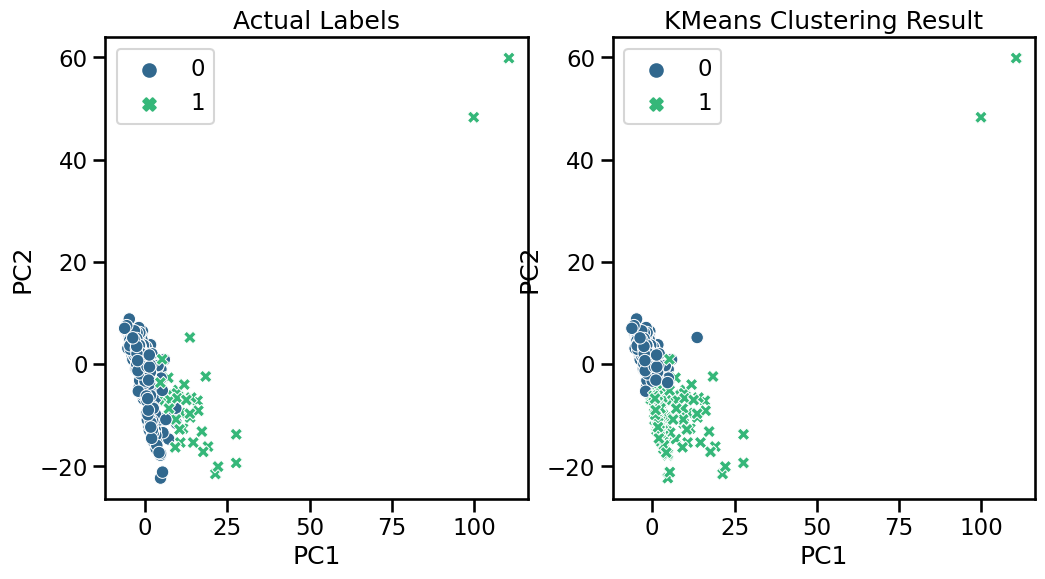

In [32]:
kmeans = KMeans(n_clusters = 2, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

actual_labels = y['label'].values

ari_score = adjusted_rand_score(actual_labels, kmeans_labels)

print(f"Adjusted Rand Index (ARI) score: {ari_score}")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)

sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=actual_labels, 
                style=actual_labels, 
                palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=kmeans_labels, 
                style=kmeans_labels, 
                palette='viridis')
plt.title('KMeans Clustering Result')
plt.show()


In [33]:
pca_df_inp = pca_df.iloc[:,:-2]
kchoices = [1,2,5,10]
thres    = [90, 95, 99]

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    X   = pca_df_inp.iloc[:,:pca_dim]
    kmeans = KMeans(n_clusters = 2, random_state=42)
    kmeans_labels = kmeans.fit_predict(X)
    
    conf_mat   = confusion_matrix(actual_labels,kmeans_labels)
    acc        = accuracy_score(actual_labels,kmeans_labels)
    recall     = recall_score(actual_labels,kmeans_labels)
    prec       = precision_score(actual_labels,kmeans_labels)
    
    if acc > best_acc or recall > best_recall or prec > best_prec:
        best_acc = acc
        best_dim = pca_dim
        best_recall  = recall
        best_prec = prec
        best_kmeans_labels = kmeans_labels
        print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
              f' {conf_mat}')
        print(f'Accuracy for {pca_dim} PCA dimensions:', 
              f' {acc:.2f}')
        print(f'Recall for {pca_dim} PCA dimensions:', 
              f' {recall:.2f}')
        print(f'Precision for {pca_dim} PCA dimensions:', 
              f' {prec:.2f}')
        print(f'---------')

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)

# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=actual_labels, 
#                 style=actual_labels, 
#                 palette='viridis')
# plt.title('Actual Labels')

# plt.subplot(1, 2, 2)
# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=knn_labels, 
#                 style=knn_labels, 
#                 palette='viridis')
# plt.title('KMeans Clustering Result')
# plt.show()

Confusion matrix for 2 PCA dimensions:
  [[570   0]
 [ 38   2]]
Accuracy for 2 PCA dimensions:  0.94
Recall for 2 PCA dimensions:  0.05
Precision for 2 PCA dimensions:  1.00
---------
Confusion matrix for 12 PCA dimensions:
  [[475  95]
 [  3  37]]
Accuracy for 12 PCA dimensions:  0.84
Recall for 12 PCA dimensions:  0.93
Precision for 12 PCA dimensions:  0.28
---------
Confusion matrix for 16 PCA dimensions:
  [[  0 570]
 [  2  38]]
Accuracy for 16 PCA dimensions:  0.06
Recall for 16 PCA dimensions:  0.95
Precision for 16 PCA dimensions:  0.06
---------
Confusion matrix for 20 PCA dimensions:
  [[ 98 472]
 [ 40   0]]
Accuracy for 20 PCA dimensions:  0.16
Recall for 20 PCA dimensions:  0.00
Precision for 20 PCA dimensions:  0.00
---------
Confusion matrix for 22 PCA dimensions:
  [[476  94]
 [  3  37]]
Accuracy for 22 PCA dimensions:  0.84
Recall for 22 PCA dimensions:  0.93
Precision for 22 PCA dimensions:  0.28
---------
Confusion matrix for 24 PCA dimensions:
  [[570   0]
 [ 39   1]]

# DBScan

Adjusted Rand Index (ARI) score: 0.1232419121070849


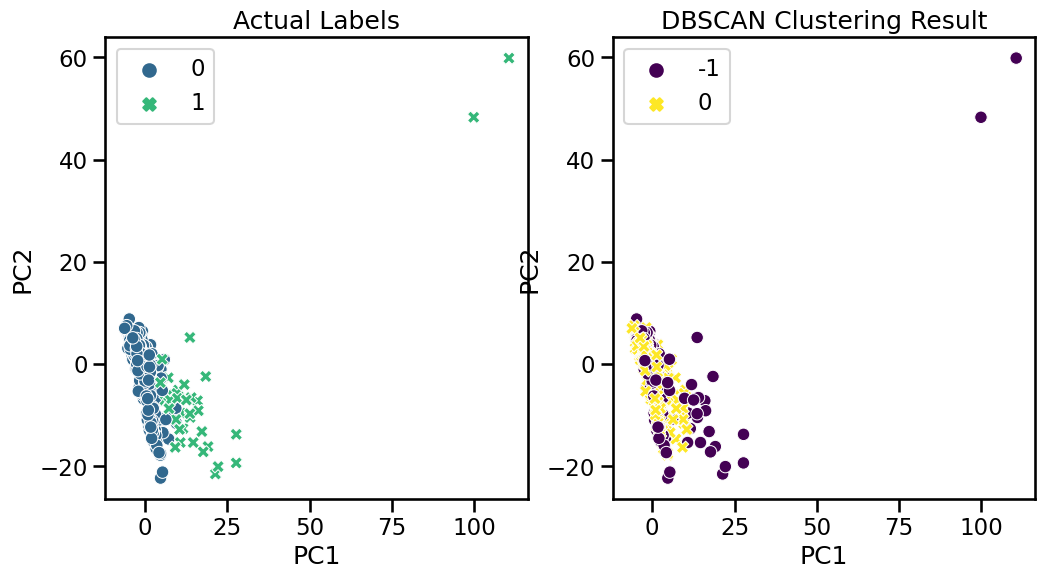

In [34]:
dbscan = DBSCAN(eps = 50, 
                min_samples = 3)

dbscan_labels = dbscan.fit_predict(X)

actual_labels = y['label'].values
ari_score = adjusted_rand_score(actual_labels, dbscan_labels)
print(f"Adjusted Rand Index (ARI) score: {ari_score}")

sns.set_context("talk")
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=actual_labels, 
                style=actual_labels, 
                palette='viridis')
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=dbscan_labels, 
                style=dbscan_labels, 
                palette='viridis')
plt.title('DBSCAN Clustering Result')
plt.show()

In [35]:
pca_df_inp = pca_df.iloc[:,:-2]
epsilons = [5,10,20,30,40,50,60,70,80,90,100]
min_samps = [2,3,4,5,10]

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    for eps in epsilons:
        for ms in min_samps:

            X   = pca_df_inp.iloc[:,:pca_dim]

            dbscan = DBSCAN(eps = eps, 
                        min_samples = ms)
            dbscan_labels = dbscan.fit_predict(X)
            dbscan_labels = np.where(dbscan_labels>=0, 0, 1)

            conf_mat   = confusion_matrix(actual_labels,dbscan_labels)
            acc        = accuracy_score(actual_labels,dbscan_labels)
            recall     = recall_score(actual_labels,dbscan_labels)
            prec       = precision_score(actual_labels,dbscan_labels)

            if acc > best_acc:
                best_acc = acc
                best_dim = pca_dim
                best_recall  = recall
                best_prec = prec
                best_dbscan_labels = dbscan_labels
                print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
                      f' {conf_mat}')
                print(f'Accuracy for {pca_dim} PCA dimensions:', 
                      f' {acc:.2f}')
                print(f'Recall for {pca_dim} PCA dimensions:', 
                      f' {recall:.2f}')
                print(f'Precision for {pca_dim} PCA dimensions:', 
                      f' {prec:.2f}')
                print(f'---------')

# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)

# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=actual_labels, 
#                 style=actual_labels, 
#                 palette='viridis')
# plt.title('Actual Labels')

# plt.subplot(1, 2, 2)
# sns.scatterplot(x=X.iloc[:, 0], 
#                 y=X.iloc[:, 1], 
#                 hue=knn_labels, 
#                 style=knn_labels, 
#                 palette='viridis')
# plt.title('KMeans Clustering Result')
# plt.show()

Confusion matrix for 2 PCA dimensions:
  [[570   0]
 [ 34   6]]
Accuracy for 2 PCA dimensions:  0.94
Recall for 2 PCA dimensions:  0.15
Precision for 2 PCA dimensions:  1.00
---------
Confusion matrix for 2 PCA dimensions:
  [[570   0]
 [ 33   7]]
Accuracy for 2 PCA dimensions:  0.95
Recall for 2 PCA dimensions:  0.17
Precision for 2 PCA dimensions:  1.00
---------
Confusion matrix for 2 PCA dimensions:
  [[570   0]
 [ 30  10]]
Accuracy for 2 PCA dimensions:  0.95
Recall for 2 PCA dimensions:  0.25
Precision for 2 PCA dimensions:  1.00
---------
Confusion matrix for 4 PCA dimensions:
  [[570   0]
 [ 24  16]]
Accuracy for 4 PCA dimensions:  0.96
Recall for 4 PCA dimensions:  0.40
Precision for 4 PCA dimensions:  1.00
---------
Confusion matrix for 4 PCA dimensions:
  [[567   3]
 [ 20  20]]
Accuracy for 4 PCA dimensions:  0.96
Recall for 4 PCA dimensions:  0.50
Precision for 4 PCA dimensions:  0.87
---------
Confusion matrix for 4 PCA dimensions:
  [[564   6]
 [  4  36]]
Accuracy for 4 P

# Isolation Forest

              precision    recall  f1-score   support

           0       0.93      1.00      0.97       570
           1       0.00      0.00      0.00        40

    accuracy                           0.93       610
   macro avg       0.47      0.50      0.48       610
weighted avg       0.87      0.93      0.90       610

Accuracy Score: 0.9344262295081968


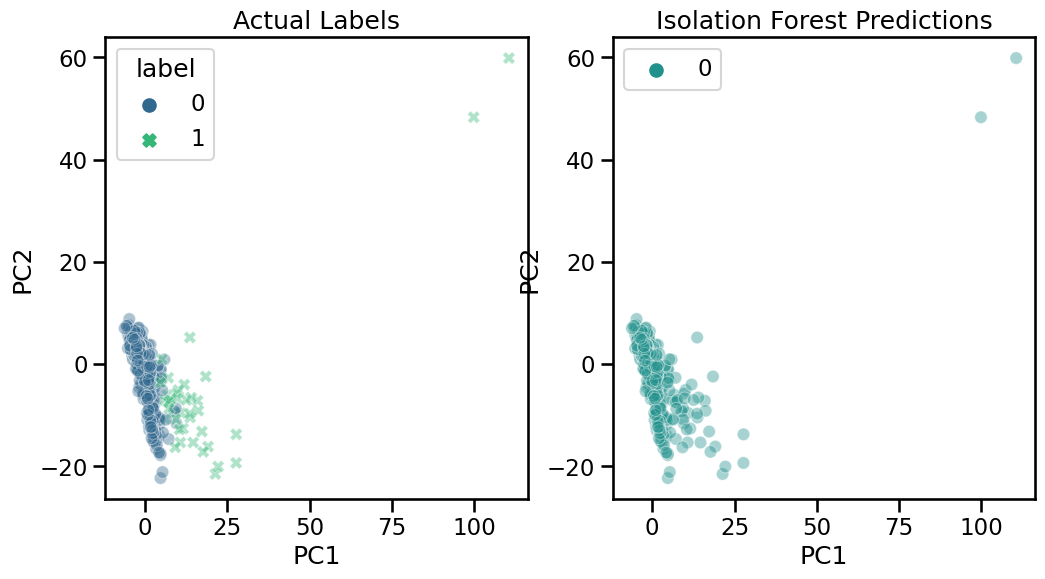

In [36]:
isolation_forest = IsolationForest(n_estimators=100, 
                                   contamination='auto', 
                                   random_state=42)

preds = isolation_forest.fit_predict(X)

binary_preds = np.where(preds == -1, 1, 0)

print(classification_report(y['label'], binary_preds))
print(f"Accuracy Score: {accuracy_score(y['label'], binary_preds)}")

plt.figure(figsize=(12, 6))
sns.set_context("talk")

plt.subplot(1, 2, 1)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=y['label'], 
                style=y['label'], 
                palette='viridis', 
                alpha = 0.4)
plt.title('Actual Labels')

plt.subplot(1, 2, 2)
sns.scatterplot(x=X.iloc[:, 0], 
                y=X.iloc[:, 1], 
                hue=binary_preds, 
                style=binary_preds, 
                palette='viridis', 
                alpha = 0.4)
plt.title('Isolation Forest Predictions')
plt.show()

In [37]:
pca_df_inp = pca_df.iloc[:,:-2]
n_estims = [5,10,50,100,150,200]

best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for pca_dim in np.linspace(2,200,100).astype(int):
    for nests in n_estims:
            X   = pca_df_inp.iloc[:,:pca_dim]
            
            isolation_forest = IsolationForest(n_estimators=100, 
                                               contamination='auto', 
                                               random_state=42)

            if_labels = isolation_forest.fit_predict(X)
            if_labels = np.where(if_labels == -1, 1, 0)

            conf_mat   = confusion_matrix(actual_labels,if_labels)
            acc        = accuracy_score(actual_labels,if_labels)
            recall     = recall_score(actual_labels,if_labels)
            prec       = precision_score(actual_labels,if_labels)

            if acc > best_acc:
                best_acc = acc
                best_dim = pca_dim
                best_recall  = recall
                best_prec = prec
                best_if_labels = if_labels
                print(f'Confusion matrix for {pca_dim} PCA dimensions:\n', 
                      f' {conf_mat}')
                print(f'Accuracy for {pca_dim} PCA dimensions:', 
                      f' {acc:.2f}')
                print(f'Recall for {pca_dim} PCA dimensions:', 
                      f' {recall:.2f}')
                print(f'Precision for {pca_dim} PCA dimensions:', 
                      f' {prec:.2f}')
                print(f'---------')


Confusion matrix for 2 PCA dimensions:
  [[525  45]
 [  0  40]]
Accuracy for 2 PCA dimensions:  0.93
Recall for 2 PCA dimensions:  1.00
Precision for 2 PCA dimensions:  0.47
---------
Confusion matrix for 4 PCA dimensions:
  [[553  17]
 [  4  36]]
Accuracy for 4 PCA dimensions:  0.97
Recall for 4 PCA dimensions:  0.90
Precision for 4 PCA dimensions:  0.68
---------
Confusion matrix for 6 PCA dimensions:
  [[560  10]
 [  2  38]]
Accuracy for 6 PCA dimensions:  0.98
Recall for 6 PCA dimensions:  0.95
Precision for 6 PCA dimensions:  0.79
---------
Confusion matrix for 8 PCA dimensions:
  [[562   8]
 [  3  37]]
Accuracy for 8 PCA dimensions:  0.98
Recall for 8 PCA dimensions:  0.93
Precision for 8 PCA dimensions:  0.82
---------
Confusion matrix for 10 PCA dimensions:
  [[566   4]
 [  4  36]]
Accuracy for 10 PCA dimensions:  0.99
Recall for 10 PCA dimensions:  0.90
Precision for 10 PCA dimensions:  0.90
---------


# Best combined:

In [38]:
best_acc = -float('inf')
best_dim = -1
best_recall = -1
best_prec = -1

for i1 in [0,1]:
    for i2 in [0,1]:
        for i3 in [0,1]:
            for i4 in [0,1]:
                for i5 in [0,1]:
                    for thresh in [0,1]:
                        tot = i1+i2+i3+i4+i5
                        comb_labels = i1*best_if_labels + i2*best_oneclass_labels + i3*best_dbscan_labels + \
                                        i4*best_kmeans_labels + i5*best_knn_labels
                        comb_labels = np.where(comb_labels > tot//2 + thresh, 1, 0)

                        conf_mat   = confusion_matrix(actual_labels,comb_labels)
                        acc        = accuracy_score(actual_labels,comb_labels)
                        recall     = recall_score(actual_labels,comb_labels)
                        prec       = precision_score(actual_labels,comb_labels)

                        if acc > best_acc:
                            best_acc = acc
                            best_dim = pca_dim
                            best_recall  = recall
                            best_prec = prec
                            best_if_labels = if_labels
                            print(f'Confusion matrix for ({i1,i2,i3,i4,i5}) included and {thresh}:\n', 
                                  f' {conf_mat}')
                            print(f'Accuracy for ({i1,i2,i3,i4,i5}) included and {thresh}:', 
                                  f' {acc:.2f}')
                            print(f'Recall for ({i1,i2,i3,i4,i5}) included and {thresh}:', 
                                  f' {recall:.2f}')
                            print(f'Precision for ({i1,i2,i3,i4,i5}) included and {thresh}:', 
                                  f' {prec:.2f}')
                            print(f'---------')

Confusion matrix for ((0, 0, 0, 0, 0)) included and 0:
  [[570   0]
 [ 40   0]]
Accuracy for ((0, 0, 0, 0, 0)) included and 0:  0.93
Recall for ((0, 0, 0, 0, 0)) included and 0:  0.00
Precision for ((0, 0, 0, 0, 0)) included and 0:  0.00
---------
Confusion matrix for ((0, 0, 0, 0, 1)) included and 0:
  [[569   1]
 [ 10  30]]
Accuracy for ((0, 0, 0, 0, 1)) included and 0:  0.98
Recall for ((0, 0, 0, 0, 1)) included and 0:  0.75
Precision for ((0, 0, 0, 0, 1)) included and 0:  0.97
---------
Confusion matrix for ((0, 0, 1, 0, 0)) included and 0:
  [[565   5]
 [  1  39]]
Accuracy for ((0, 0, 1, 0, 0)) included and 0:  0.99
Recall for ((0, 0, 1, 0, 0)) included and 0:  0.97
Precision for ((0, 0, 1, 0, 0)) included and 0:  0.89
---------
